# CatBoost (Gradient-boosting), performance between customer order quantities

In [1]:
%pip install nbformat pandas numpy matplotlib seaborn scikit-learn catboost 


[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
import sys
sys.path.append('../../src')

In [4]:
from data_config import ProductHandler as ph

/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/catboost/../../src/datasets.py:13: DtypeWarning: Columns (4,6,20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  products_s = pd.read_csv(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/catboost/../../src/datasets.py:15: DtypeWarning: Columns (5,29,42,48) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_i = pd.read_csv(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/catboost/../../src/datasets.py:18: DtypeWarning: Columns (43,57,106,141,146,211,212,247,255,294,298,316,327,332,350,354) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_m = pd.read_csv(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/catboost/../../src/datasets.py:21: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  sp_inv_adds = pd.read_csv(


----- DROP BOOLEAN AND NULL COLUMNS (NOT NEEDED) -----

Merged Data - Columns to be dropped (Missing Vals): ['BackStage_DefaultReportForm', 'BackStage_SmartMarkSet', 'BillCounty', 'CoreType', 'EndUserNum', 'EndUserPO', 'Equip3_ID', 'Equip3_Status', 'Est_v_Act_Notes', 'Ink_Status', 'JDF_Note_to_DFE', 'JDF_Send_Msg', 'MiscChargeDesc1', 'MiscChargeDesc2', 'MiscChargeDesc3', 'MiscChargeDesc4', 'PlateStat', 'ProofStat', 'Roto_CEL_Product_ID', 'Roto_Quote_Line_ID', 'Roto_Quote_Number', 'Schedule_Status', 'ShipAttn_EmailAddress', 'ShipCounty', 'ShipStat', 'Tag_x', 'Tool3Descr', 'Tool4Descr', 'Tool5Descr', 'ToolNo3', 'ToolNo4', 'ToolNo5', 'ToolStat', 'UserDef_MR_1_Lb', 'UserDef_MR_2_Lb', 'Assigned', 'Desc2_x', 'ediLineNumber', 'eTraxx_Customer_Notes', 'Location_x', 'PO_Number', 'Adhesive', 'Alternate', 'eTraxx_Forecast_Range', 'Material', 'Tag_y', 'UPC']

Merged Data - Columns to be dropped (All cols with rows same vals): ['Act_OTHER_Hours', 'ActArtwork', 'ActFinMaterial', 'ActPostPressHours',

/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/catboost/../../src/datasets.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['OrderDate'] = pd.to_datetime(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/catboost/../../src/datasets.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['OrderDate'] = pd.to_datetime(
/Users/mwilko777/Desktop/Project/Software Artifact/notebooks/catboost/../../src/datasets.py:110: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and a

In [5]:
ph.custom_prod_set()

All custom codes for existing products: 
{'07Y', '760', '691', '339', 'L10', 'SRF', '46V', '61X', 'UNC', '994', '54X', '360', '687', '22T', '454', 'GDW', 'PJR', '350', 'AM-', '50V', '379', '365', '258', '56W', '11S', '064', '305', 'FLA', '27T', 'AL-', '206', '95Z', '851', '024', 'CI-', '18U', '405', 'CCM', '073', '238', 'B-0', 'ALP', '082', 'MDA', '19T', '784', '901', '831', 'K-T', '885', '19Z', 'ODO', '7X-', 'FS-', '88Y', '11Z', '806', '978', '-JA', '07U', '371', 'UG-', 'DMO', '427', '245', '1Z-', '040', 'ZU-', '804', '510', '30T', '805', 'LA-', 'PJ-', '17Z', 'FIF', 'R-T', '848', '619', '45T', '657', '485', '09T', '007', 'FF-', '49X', '099', '773', '282', '67U', '644', '10T', 'AZ-', '627', '023', '725', 'AFS', '120', '090', '955', '337', '30-', '298', 'MMW', 'TNS', '731', 'OY-', '827', '927', '00V', 'SSS', 'ARO', '63R', '79Z', '47U', '076', '-PP', '098', '128', 'EB-', 'GRP', '285', '521', '918', 'RS-', '72W', '604', '10X', '27U', '10R', '798', 'T-T', 'CHB', '888', 'HBK', 'TC-', '678',

In [6]:
# define the features and target variable from 'product_sales'
# CHANGE THE CUSTOMER CODE HERE >>>>>>>>>>
custom_code_df = pd.DataFrame(ph.get_custom_code_data('ALB'))

# customer code for later referencing
custom_ref = custom_code_df.loc[0, 'ProductNumber'][:3].lower().upper()
print(custom_ref)

custom_code_df.head()

ALB


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,OrderDate,Customer_Num,OrderQuantity,prev_month_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,ALB-005-0022Y,2024,9,39,0,0,2024-09-23,191.0,160000,110031.53337,...,160000.000000,160000.000000,160000.000000,160000.000000,0,0,160000,NaN,inf,8000
1,ALB-005-0022Z,2024,7,30,1,0,2024-07-23,191.0,96000,110031.53337,...,96000.000000,96000.000000,96000.000000,96000.000000,0,0,96000,NaN,inf,0
2,ALB-005-0023Y,2024,11,45,1,0,2024-11-05,191.0,72000,88000.00000,...,57333.333333,57333.333333,57333.333333,57333.333333,0,0,72000,NaN,inf,8000
3,ALB-005-0023Y,2024,12,1,0,0,2024-12-30,191.0,12000,110031.53337,...,12000.000000,12000.000000,12000.000000,12000.000000,0,0,12000,NaN,inf,8000
4,ALB-005-0023Y,2024,12,49,3,0,2024-12-05,191.0,88000,12000.00000,...,50000.000000,50000.000000,50000.000000,50000.000000,0,0,88000,NaN,inf,8000


In [7]:
from app_utils import Transform as trans
from model_utils import *
from sklearn.pipeline import Pipeline

In [8]:
# Compute OrderQuantity values with a zscore with threshold of 3 and remove them (Outlier removal)
custom_code_df = trans.compute_zscore(custom_code_df)

custom_code_df.head()

ProductNumber  order_year  order_month  order_week  \
ProductNumber                                                         
ALB-005-0023Y 2  ALB-005-0023Y        2024           11          45   
              3  ALB-005-0023Y        2024           12           1   
              4  ALB-005-0023Y        2024           12          49   
ALB-005-0024X 7  ALB-005-0024X        2024           10          40   
              8  ALB-005-0024X        2024           11          47   

                 order_weekday  is_weekend  OrderDate  Customer_Num  \
ProductNumber                                                         
ALB-005-0023Y 2              1           0 2024-11-05         191.0   
              3              0           0 2024-12-30         191.0   
              4              3           0 2024-12-05         191.0   
ALB-005-0024X 7              5           1 2024-10-05         191.0   
              8              5           1 2024-11-23         191.0   

                 OrderQuantity  prev_month_sales  ...  moving_avg_6m  \
ProductNumber                                     ...                  
ALB-005-0023Y 2          72000       88000.00000  ...   57333.333333   
              3          12000      110031.53337  ...   12000.000000   
              4          88000       12000.00000  ...   50000.000000   
ALB-005-0024X 7         160000       32000.00000  ...   73600.000000   
              8          32000       64000.00000  ...   52000.000000   

                 moving_avg_12m  moving_avg_18m  sales_2022  sales_2023  \
ProductNumber                                                             
ALB-005-0023Y 2    57333.333333    57333.333333           0           0   
              3    12000.000000    12000.000000           0           0   
              4    50000.000000    50000.000000           0           0   
ALB-005-0024X 7    73600.000000    73600.000000           0           0   
              8    52000.000000    52000.000000           0           0   

                 sales_2024  growth_2023  growth_2024  PhysicalInv   z_score  
ProductNumber                                                                 
ALB-005-0023Y 2       72000          NaN          inf         8000  0.448327  
              3       12000          NaN          inf         8000  1.385737  
              4       88000          NaN          inf         8000  0.937410  
ALB-005-0024X 7      160000          NaN          inf        36000  1.928571  
              8       32000          NaN          inf        36000  0.928571  

[5 rows x 35 columns]

In [9]:
X = custom_code_df.drop('OrderQuantity', axis=1)
y = custom_code_df.OrderQuantity

In [10]:
# Trian and transforms data (CatBoost transforms natively so might not need to transform)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_preprocessed, X_val_preprocessed = trans.transform_data(X_train, X_val, X)

In [11]:
from catboost import CatBoostRegressor

In [12]:
catboost_model = CatBoostRegressor(
    cat_features=[ # Specify catagorical features for cat model, else model fails to compute
        'ProductNumber',
        # 'order_month', 
        # 'order_week', 
        # 'order_weekday'
        ],
    silent=True # Disable for training logs
)

In [13]:
# Hyperparam tuning = 120mins (best parameters are found and used)
# catb_params = find_best_hyperparameters(catboost_model, param_grids(CatBoostRegressor().__class__.__name__), X_train, y_train)

In [ ]:
# Train and get metric scores of CatBoost with best parameters
catb_tuned = CatBoostRegressor(
    # col_sample_bylevel=0.8,
    depth=6,
    grow_policy='Depthwise',
    iterations=1000,
    l2_leaf_reg=3,
    learning_rate=0.03,
    min_data_in_leaf=5,
    subsample=1.0,
    random_state=42,
    # Specify prodnum which is formatted as str 'FRE-005-0344Z' because it cannot be parsed
    cat_features=['ProductNumber'],
    silent=True # Disable for training logs
)

catb_tuned.fit(X_train, y_train)

print('----------- TRAINING METRICS -----------')
train_metrics = evaluate_model(catb_tuned, X_train, y_train)
print('\n\n')
print('----------- TESTING METRICS -----------')
test_metrics = evaluate_model(catb_tuned, X_val, y_val)

----------- TRAINING METRICS -----------
Mean Absolute Error (MAE): 2393.3367
Mean Squared Error (MSE): 16059487.6822
Root Mean Squared Error (RMSE): 4007.4291
R-squared (R²): 0.9998



----------- TESTING METRICS -----------
Mean Absolute Error (MAE): 10046.8383
Mean Squared Error (MSE): 1597488763.6408
Root Mean Squared Error (RMSE): 39968.5972
R-squared (R²): 0.9811


In [ ]:
# Get model predictions
y_train_pred = catb_tuned.predict(X_train)
y_val_pred = catb_tuned.predict(X_val)

In [16]:
# Create a DetailedOrderDate column using week and weekday information.
custom_code_df['DetailedOrderDate'] = pd.to_datetime(
    custom_code_df['order_year'].astype(str) +
    custom_code_df['order_week'].astype(str).str.zfill(2) +
    custom_code_df['order_weekday'].astype(str),
    format='%Y%W%w'
)

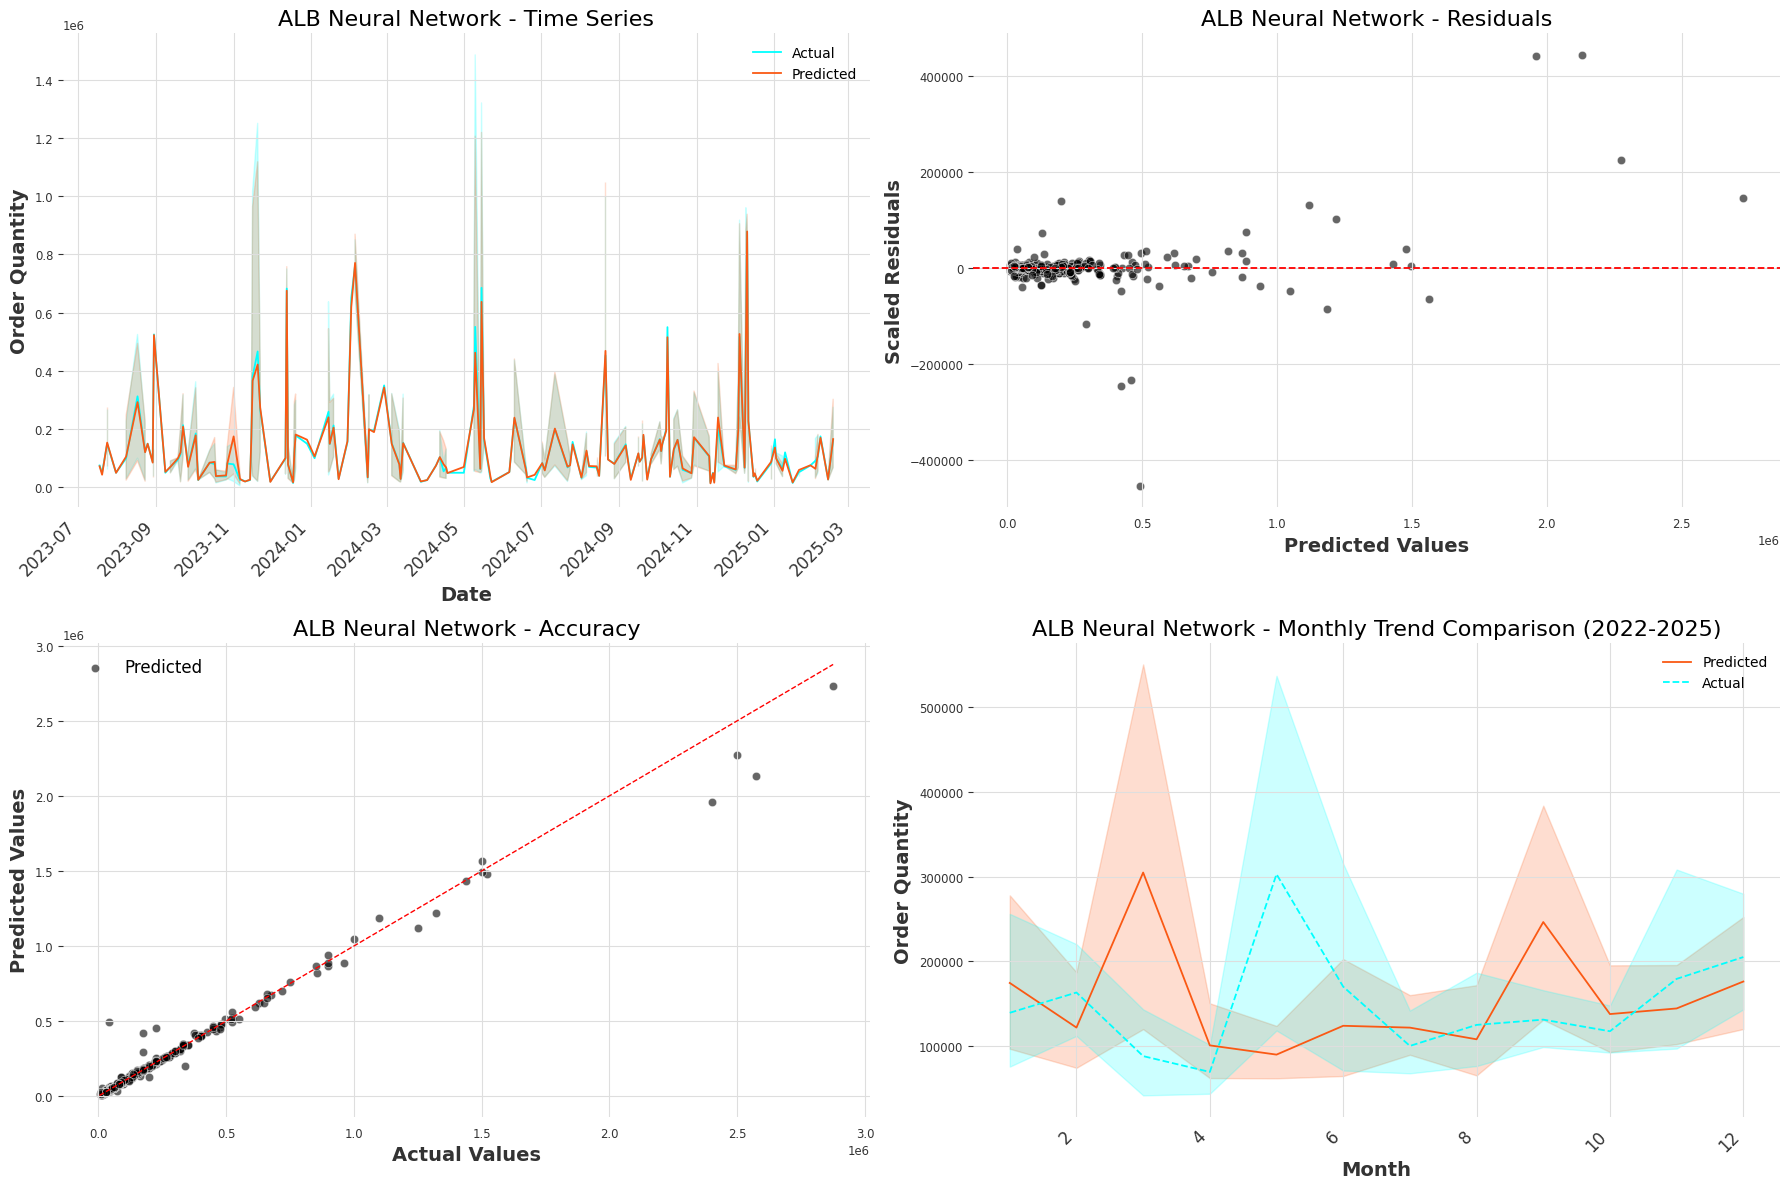

In [17]:
# Create subplots (2 rows, 2 columns: one for line plot, one for residual plot)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12)) 
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# Time Series Comparison
sns.lineplot(x=custom_code_df.loc[y_val.index, 'OrderDate'], y=y_val, label='Actual', color='cyan', ax=axes[0, 0])
sns.lineplot(x=custom_code_df.loc[y_val.index, 'OrderDate'], y=y_val_pred, label='Predicted', color='#fa5914', ax=axes[0, 0])
axes[0, 0].set_title(f'{custom_ref} Neural Network - Time Series', fontsize=16)
axes[0, 0].set_xlabel('Date', fontsize=14)  
axes[0, 0].set_ylabel('Order Quantity', fontsize=14)

# Residual Plot
residuals = y_val - y_val_pred
sns.scatterplot(x=y_val_pred, y=residuals, alpha=0.6, ax=axes[0, 1])
axes[0, 1].axhline(0, color='r', linestyle='--')
axes[0, 1].set_title(f'{custom_ref} Neural Network - Residuals', fontsize=16)  
axes[0, 1].set_xlabel('Predicted Values', fontsize=14)  
axes[0, 1].set_ylabel('Scaled Residuals', fontsize=14)

# Actual vs Predicted Scatter Plot
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, ax=axes[1, 0], label='Predicted')
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)  # Reference line
axes[1, 0].set_title(f'{custom_ref} Neural Network - Accuracy', fontsize=16)
axes[1, 0].set_xlabel('Actual Values', fontsize=14)
axes[1, 0].set_ylabel('Predicted Values', fontsize=14)  
axes[1, 0].legend(fontsize=12)

# Monthly Trend Comparison
monthly_data = custom_code_df[['order_month']].loc[custom_code_df.index.intersection(X_val.index)].copy()
monthly_data['Actual'] = y_val
monthly_data['Predicted'] = y_val_pred

sns.lineplot(x='order_month', y='Predicted', data=monthly_data, label='Predicted', color='#fa5914', ax=axes[1, 1])
sns.lineplot(x='order_month', y='Actual', data=monthly_data, label='Actual', color='cyan', ax=axes[1, 1], linestyle='--')
axes[1, 1].set_title(f'{custom_ref} Neural Network - Monthly Trend Comparison (2022-2025)', fontsize=16)  
axes[1, 1].set_xlabel('Month', fontsize=14)
axes[1, 1].set_ylabel('Order Quantity', fontsize=14)

# Adjust x-tick labels
plt.setp(axes[0, 0].get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right', fontsize=12)

plt.tight_layout()
plt.show()